## **GQME Tutorial**


## **1. Connecting to Google Drive**

This section is required if running in Google Collab, otherwise it is unnecessary.

In [ ]:
import os
from google.colab import drive
drive.mount('/content/mydir')
os.chdir('/content/mydir/MyDrive/GQME_Tutorial')


## **2. Importing Libraries**

In [1]:
import sys, os

import numpy as np
import math
from scipy import interpolate
from pprint import pprint

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib.lines import Line2D
import matplotlib as mpl
mpl.style.use('classic')
from functions import *


## **3. Global Constants and Variables**

These constants and variables are used in multiple sections of the code, so they are put at the beginning.


In [2]:
# general constants
TIME_STEPS = 2000 # number of time steps
tau = 5              # propagation time step
au2ps = 0.00002418884254 # Conversion of attoseconds to atomic units
timeau = 12.409275
DT = tau * au2ps * timeau # time step in au
FINAL_TIME = TIME_STEPS * DT # final time
DOF_E = 2 # number of electronic states
DOF_E_SQ = DOF_E * DOF_E
DOF_N = 60 # number of nuclear DOF
HBAR = 1

### constants related to the model number ###
MODEL_NUM = 2 # model number

# setting parameters that based on the model number
BETA = 5 # inverse finite temperature beta = 1 / (k_B * T)
GAMMA_DA = 1 # diabatic coupling
if MODEL_NUM == 1:
    EPSILON = 1    # half of the energy gap between the donor and acceptor
    XI = 0.1       # friction coefficient, determines strength of e-n coupling
    OMEGA_C = 1    # cutoff frequency of the nuclear DOF
    OMEGA_MAX = 5  # maximum frequency of the nuclear DOF
elif MODEL_NUM == 2:
    EPSILON = 1
    XI = 0.1
    OMEGA_C = 2
    OMEGA_MAX = 10
elif MODEL_NUM == 3:
    EPSILON = 1
    XI = 0.1
    OMEGA_C = 7.5
    OMEGA_MAX = 36
elif MODEL_NUM == 4:
    EPSILON = 1
    XI = 0.4
    OMEGA_C = 2
    OMEGA_MAX = 10
elif MODEL_NUM == 6:
    EPSILON = 0
    XI = 0.2
    OMEGA_C = 2.5
    OMEGA_MAX = 12

### setting parameter string ###
PARAM_STR = "_Spin-Boson_Ohmic_TT-TFD_b%sG%s_e%s_t%.8f_"%(BETA, GAMMA_DA, EPSILON, DT)
PARAM_STR += "xi%swc%s_wmax%s_dofn%s_tf%.4f"%(XI, OMEGA_C, OMEGA_MAX, DOF_N, FINAL_TIME)

## **4. Variables Defining the Subset of Interest**

## **4.1 Constants**

$\quad$ This subsection defines the constants related to the GQME type being calculated. The types of GQMEs allowed are the full GQME (all electronic states); the populations-only GQME (only the populations); a single-state GQME, with the single state designated in this subsection; and a subset of states GQME, with the subset designated in this subsection. This is done within the array \verb|"STATES"|, which should have the state(s) in the subset of interest. For subsets, it is logical (but not technically necessary) to put the order of states following the normal order; i.e., "00" should be listed before "01", which should be before "10", which should be before "11".


In [3]:
GQME_TYPE = "SingleState"
# type of reduced (or full) GQME.
# options: Full, PopulationsOnly, SingleState, SubsetStates
STATES = ["11"]
# state(s) to be looking at for SingleState or SubsetStates. It isn't
# necessary to set this for Full or PopulationsOnly because the code is designed
# to create the right arrays for those automatically.
INITIAL_STATE = "00" # initial state

## **4.2 Variables**



$\quad$ This subsection creates variables based on the GQME type defined in Sec. 2.1. The variables that need to be defined are the number of states in the subset of interest and an array of the indices in the subset of interest.


In [4]:
### setting the number of states and array of states strings based on the
### GQME_TYPE
states = [] # array with states in the subset of interest
initInSubset = False
if GQME_TYPE == "Full":
    numStates = DOF_E_SQ # number of states in subset
    for i in range(DOF_E):
        for j in range(DOF_E):
            statesStr = "%s%s"%(i,j)
            states.append(statesStr)

    initInSubset = True
    initialIndex = DOF_E * int(INITIAL_STATE[0]) + int(INITIAL_STATE[1])

elif GQME_TYPE == "PopulationsOnly":
    numStates = DOF_E
    for i in range(DOF_E):
        statesStr = "%s%s"%(i,i)
        states.append(statesStr)

    initInSubset = True
    initialIndex = int(INITIAL_STATE[0])

elif GQME_TYPE == "SubsetStates":
    numStates = len(STATES)
    states = STATES

    if INITIAL_STATE in states:
        initInSubset = True
        initialIndex = states.index(INITIAL_STATE)
elif GQME_TYPE == "SingleState":
    numStates = len(STATES)
    states = STATES
    if numStates != 1:
        print("ERROR: More than one state in STATES with GQME_TYPE = SingleState")

    if states[0] == INITIAL_STATE:
        initInSubset = True
        initialIndex = 0
else:
    print("ERROR: GQME_TYPE not Full, PopulationsOnly, SubsetStates, or SingleState.")

### print statements ###
print("Calculating the", GQME_TYPE, "GQME")
if GQME_TYPE == "SubsetStates":
    printStr = "\tSubset of states is "
    for i in range(numStates):
        printStr += "%s, "%states[i]
    print(printStr)
elif GQME_TYPE == "SingleState":
    print("\tState being calculated is", states[0])

Calculating the SingleState GQME
	State being calculated is 11


## **5. Liouvillian Matrix**

$\quad$ This section defines $\langle{\cal L}\rangle_n^0 = \text{Tr}\big\{{\cal L}\hat\rho_n(0)\big\}$: the expectation value of the Liouvillian, ${\cal L}(\cdot) = [\hat H, \,\cdot\,]$, with respect to the initial states of the nuclear DOF, $\hat\rho_n(0)$. For the spin-boson model, $\langle{\cal L}\rangle_n^0$ is given by:

\begin{align}
\langle{\cal L}\rangle_n^0 =
\left(
    \begin{array}{cccc}
    0 & -\Gamma & \Gamma & 0
	\\[0.25em] -\Gamma & 2\epsilon& 0 & \Gamma
	\\[0.25em] \Gamma & 0 & -2\epsilon & -\Gamma
	\\[0.25em] 0 & \Gamma & - \Gamma & 0
    \end{array}
\right).
\end{align}



In [5]:
LN0 = np.zeros((DOF_E_SQ, DOF_E_SQ))
LN0[0][1] = LN0[1][0] = LN0[2][3] = LN0[3][2] = -GAMMA_DA
LN0[0][2] = LN0[2][0] = LN0[1][3] = LN0[3][1] = GAMMA_DA
LN0[1][1] = 2. * EPSILON
LN0[2][2] = -2. * EPSILON

print(r'Gamma_DA =', GAMMA_DA, '      epsilon =', EPSILON)
print('\n<L>_N^0 =')
pprint(LN0)

Gamma_DA = 1       epsilon = 1

<L>_N^0 =
array([[ 0., -1.,  1.,  0.],
       [-1.,  2.,  0.,  1.],
       [ 1.,  0., -2., -1.],
       [ 0.,  1., -1.,  0.]])


## **6. Calculating the Memory Kernel**

$\quad$ The Volterra equation for the memory kernel is given by Eq. \ref{eq:Kvolt_sub}, copied below

\begin{align}
{\cal K}_{jk,lm}^{\text{sub}}(\tau) &= i\dot{\cal F}_{jk,lm}(\tau) - \frac{1}{\hbar} \sum_{uv\,\in\{ab\}} {\cal F}_{jk,uv}(\tau) \langle{\cal L}_{uv,lm}\rangle_n^0 \notag \\
& + i \sum_{uv\,\in\{ab\}} \int_0^\tau d\tau' {\cal F}_{jk,uv}(\tau - \tau') {\cal K}_{uv,lm}^{\text{sub}}(\tau')
\end{align}


$\quad$ In the following subsections, we will calculate the memory kernel using an iterative algorithm with ${\cal F}(\tau)$ and $\dot{\cal F}(\tau)$ as inputs.

$\quad$ The calculation of the memory kernel of each subset of interest is independent of calculating any other memory kernel, so in practice when we have multiple subsets of interest, their memory kernels are calculated in parallel.


## **6.1 Constants**

$\quad$ This subsection defines the constants and global variables used within the memory kernel calculation.

In [6]:
### specific constants to the memory kernel code ###
INTEGRAL_STEP_K = (TIME_STEPS * DT - DT)/(TIME_STEPS - 1)
# size of slice in integral, often written h = (x_b - x_a)/N
# [[Note: N = TIME_STEPS - 1 because there are TIME_STEPS - 1 slices, since
#   TIME_STEPS includes a count for t = 0]]
MAX_ITERS = 30 # maximum number of iterations for K
CONVERGENCE_PARAM = 10.**(-10.) # convergence parameter for volterra iterations

## **6.2 Read in Time Vector and Projection-Free Inputs ${\cal F}(\tau)$ and $\dot{\cal F}(\tau)$**

$\quad$ This subsection reads in the values of time and the projection-free inputs (PFIs) ${\cal F}(\tau)$ and $\dot{\cal F}(\tau)$ from files.


In [7]:
# variables
timeVec = np.zeros((TIME_STEPS))
F = np.zeros((TIME_STEPS, numStates, numStates), dtype=np.complex_)
Fdot = np.zeros((TIME_STEPS, numStates, numStates), dtype=np.complex_)

# loop to read in each element
for j in range(numStates):
    for k in range(numStates):
        # defining indices of PFI element from states array
        statesStr = states[j] + states[k]

        # reading in F
        t, Freal, Fimag = np.hsplit(
            np.loadtxt("ProjFree_Output/F_" + statesStr + PARAM_STR
                           + ".txt"), 3)

        # reading in Fdot
        t, Fdotreal, Fdotimag = np.hsplit(
            np.loadtxt("ProjFree_Output/Fdot_" + statesStr + PARAM_STR
                           + ".txt"), 3)

        # storing values to variables and combining real and imag parts of F and Fdot
        for i in range(TIME_STEPS):
            timeVec[i] = t[i]
            F[i][j][k] = Freal[i] + 1.j * Fimag[i]
            Fdot[i][j][k] = Fdotreal[i] + 1.j * Fdotimag[i]

## **6.3 Linear Term**

$\quad$ The Volterra equation for the memory kernel is given in the equation below

\begin{align}
{\cal K}_{jk,lm}^{\text{sub}}(\tau) & = i\dot{\cal F}_{jk,lm}(\tau) - \frac{1}{\hbar} \sum_{uv\,\in\{ab\}} {\cal F}_{jk,uv}(\tau) \langle{\cal L}_{uv,lm}\rangle_n^0 \notag \\
&+ i \sum_{uv\,\in\{ab\}} \int_0^\tau d\tau' {\cal F}_{jk,uv}(\tau - \tau') {\cal K}_{uv,lm}^{\text{sub}}(\tau')
\end{align}

$\quad$ This subsection calculates and stores the linear part of the RHS of Eq. \ref{eq:Kvolt_sub}: $i\dot{\cal F}_{jk,lm}(\tau) - \frac{1}{\hbar} \sum_{uv\,\in\{ab\}} {\cal F}_{jk,uv}(\tau) \langle{\cal L}_{uv,lm}\rangle_n^0$.


In [8]:
linearTerm = 1.j * Fdot.copy() # first term of the linear part
for i in range(numStates):
    for j in range(numStates):
        for l in range(TIME_STEPS):
            for k in range(numStates):
                # determines indices of <L>_n^0 matrix
                index1 = DOF_E * int(states[k][0]) + int(states[k][1])
                index2 = DOF_E * int(states[j][0]) + int(states[j][1])

                # subtracts second term of linear part
                linearTerm[l][i][j] -= 1./HBAR * F[l][i][k] * LN0[index1][index2]

## **6.4 Iterative Volterra Algorithm**

$\quad$ These subsections will calculate the memory kernel via an interative algorithm. Starting with the general formula for a convolution Volterra equation of the second kind:
\begin{equation*}
{\cal K}(t) = g(t) + \int_{0}^t f(t - \tau){\cal K}(\tau)d\tau
\end{equation*}

$\quad$ The iterative algorithm works by starting with a guess of ${\cal K}(t) = g(t)$ and keeps replacing it until it converges:
\begin{align*}
{\cal K}^{\color{purple} 0}(t) &= g(t)
\\ {\cal K}^{\color{purple} 1}(t) &= g(t) + \int_{0}^t d\tau f(t - \tau) {\cal K}^{\color{purple} 0}(\tau)
\\ {\cal K}^{\color{purple} 2}(t) &= g(t) + \int_{0}^t d\tau f(t - \tau) {\cal K}^{\color{purple} 1}(\tau)
\\ \vdots
\\ {\cal K}^{\color{purple} i}(t) &= g(t) + \int_{0}^t d\tau f(t - \tau) {\cal K}^{\color{purple} i-1}(\tau) \quad  \text{where} \quad |{\cal K}^{\color{purple} i}(t) - {\cal K}^{\color{purple} i-1}(t)|\ \leq 10^{-10}
\end{align*}

$\quad$ To do this in an algorithm, we calculate ${\cal K}(n\Delta t)$ [where $n = 0, 1, 2, ..., N$ and $N\Delta t = t$] at many time steps and store them to get ${\cal K}^{\color{purple} iteration}(n\Delta t)$:
\begin{align*}
{\cal K}^{\color{purple} 0}(n\Delta t) &= g(n\Delta t)
\\ {\cal K}^{\color{purple} 1}(n\Delta t) &= g(n\Delta t) + \int_0^{n\Delta t} d\tau f(n\Delta t - \tau) {\cal K}^{\color{purple} 0}(\tau)
\\ {\cal K}^{\color{purple} 2}(n\Delta t) &= g(n\Delta t) + \int_0^{n\Delta t} d\tau f(n\Delta t - \tau) {\cal K}^{\color{purple} 1}(\tau)
\\ \vdots
\\ {\cal K}^{\color{purple} i}(n\Delta t) &= g(n\Delta t) + \int_0^{n\Delta t} d\tau f(n\Delta t - \tau) {\cal K}^{\color{purple} i-1}(\tau) \quad  \text{where} \quad |{\cal K}^{\color{purple} i}(n\Delta t) - {\cal K}^{\color{purple} i-1}(n\Delta t)|\ \leq 10^{-10}
\end{align*}

$\quad$ The algorithm works by first calculating the integral from $0$ to $n\Delta t$ using the trapezoidal rule with $f(n\Delta t - \tau)$ and ${\cal K}^{\color{purple} i-1}(s)$ and then adding $g(n\Delta t)$ to get ${\cal K}^{\color{purple} i}(n\Delta t)$.

$\quad$ To check convergence, we see if $\ |{\cal K}_{jk,lm}^{\text{sub},\ {\color{purple} i}}(n\Delta t) - {\cal K}_{jk,lm}^{\text{sub},\ {\color{purple} i-1}}(n\Delta t)| \leq 10^{-10}\ $ for all matrix elements $j,k,l,m$ and time steps $n$.



## **6.4.1 Function to Calculate Integral via Trapezoidal Rule**

$\quad$ This function calculates the integral part of the Volterra equation,
\begin{align}
i \sum_{uv\,\in\{ab\}} \int_0^\tau d\tau' {\cal F}_{jk,uv}(\tau - \tau') {\cal K}_{uv,lm}^{\text{sub}}(\tau')
\end{align}
via the extended trapezoidal rule and then adding the linear part calculated in Sec. \ref{sec:memlinear}.

$\quad$ The extended trapezoidal rule approximates an integral on a uniform grid with $N$ slices as:
\begin{align}
\int_a^b f(t) dt \approx h\bigg[\frac{1}{2} f(a) + \frac{1}{2} f(b) + \sum_{k = 1}^{N-1} f(a + k * h)\bigg],
\end{align}

where $h = (a - b)\,/\,N$.


In [9]:
def CalculateIntegral(numStates, F, linearTerm, prevKernel, kernel):
    global TIME_STEPS, INTEGRAL_STEP_K # this is spacing h

    # time step loop starts at 1 because K is equal to linear part at t = 0
    for n in range(1, TIME_STEPS):
        for i in range(numStates):
            for j in range(numStates):
                kernel[n][i][j] = 0.
                for k in range(numStates):
                    # f(a) and f(b) terms
                    kernel[n][i][j] += 0.5 * INTEGRAL_STEP_K * F[n][i][k] * kernel[0][k][j]
                    kernel[n][i][j] += 0.5 * INTEGRAL_STEP_K * F[0][i][k] * prevKernel[n][k][j]

                    # sum of f(a + kh) term
                    for c in range(1, n):
                        # since a new (supposed-to-be-better) guess for the
                        # kernel has been calculated for previous time steps,
                        # can use it rather than prevKernel
                        kernel[n][i][j] += INTEGRAL_STEP_K * F[n - c][i][k] * kernel[c][k][j]

                # multiplies by i and adds the linear part
                kernel[n][i][j] = 1.j * kernel[n][i][j] + linearTerm[n][i][j]

    return kernel

## **6.4.2 Volterra Algorithm**


$\quad$ This section actually calculates the iterative Volterra algorithm described in Sec. 3.4.


In [10]:
# initializes previous kernel and kernel
prevKernel = np.zeros((TIME_STEPS, numStates, numStates), dtype=np.complex_)
kernel = np.zeros((TIME_STEPS, numStates, numStates), dtype=np.complex_)

# sets initial guess to the linear part
prevKernel = linearTerm.copy()
# sets kernel at t = 0 to linear part (no integral at t = 0)
kernel[0] = linearTerm[0].copy()

# loop for iterations
for numIter in range(1, MAX_ITERS + 1):
    print("Iteration:", numIter)

    # calculates kernel using prevKernel and trapezoidal rule
    kernel = CalculateIntegral(numStates, F, linearTerm, prevKernel, kernel)

    numConv = 0 # parameter used to check convergence of entire kernel
    for i in range(numStates):
        for j in range(numStates):
            for n in range(TIME_STEPS):
                # if matrix element and time step of kernel is converged, adds 1
                if abs(kernel[n][i][j] - prevKernel[n][i][j]) <= CONVERGENCE_PARAM:
                    numConv += 1

                # if at max iters, prints which elements and time steps did not
                # converge and prevKernel and kernel values
                elif numIter == MAX_ITERS:
                    print("\tK time step and matrix element that didn't converge: %s, %s%s"%(n,i,j))
                    print("\t\tprevKernel:", prevKernel[n][i][j])
                    print("\t\t    kernel:", kernel[n][i][j])

    # enters if all times steps and matrix elements of kernel converged
    if numConv == TIME_STEPS * numStates * numStates:
        # prints number of iterations necessary for convergence
        print("Number of Iterations:", numIter)
        # prints memory kernel to files
        PrintKernel(numStates, timeVec, kernel)


        PrintKernel(numStates, timeVec, kernel)

        break # exits the iteration loop

    # if not converged, stores kernel as prevKernel, zeros the kernel, and then
    # sets kernel at t = 0 to linear part
    prevKernel = kernel.copy()
    kernel = np.zeros((TIME_STEPS, numStates, numStates), dtype=np.complex_)
    kernel[0] = linearTerm[0].copy()

    # if max iters reached, prints lack of convergence
    if numIter == MAX_ITERS:
        print("\tERROR: Did not converge for %s iterations"%MAX_ITERS)

        print("\tVolterra time:", printTime(timeModule.time() - START_TIME))

Iteration: 1
Iteration: 2
Iteration: 3
Number of Iterations: 3


## **6.5 Graphing the Memory Kernel**

$\quad$ This subsection will graph the memory kernel(s) based on the GQME types specified in the array "GQMETypes". There is an additional array necessary, "statesPerType", that specifies the states that are part of each GQME type in "GQMETypes". Therefore, "statesPerType" needs to be an array of arrays that is the same length overall as "GQMETypes".

$\quad$ For single-state and subset-states GQMEs in "GQMETypes", the matching element within "statesPerType" should be an array of strings specifying the indices of the state(s) within the subset of interest.

$\quad$ For full and populations-only GQMEs, it isn't necessary to specify the states but an array must be put in the matching spot with a placeholder string in order to ensure any single-state or subset-states GQME is able to match indices between "GQMETypes" and "statesPerType".

$\quad$ The graphs will be a square grid, from 1x1 to 4x4, depending on the GQME type(s) of interest.

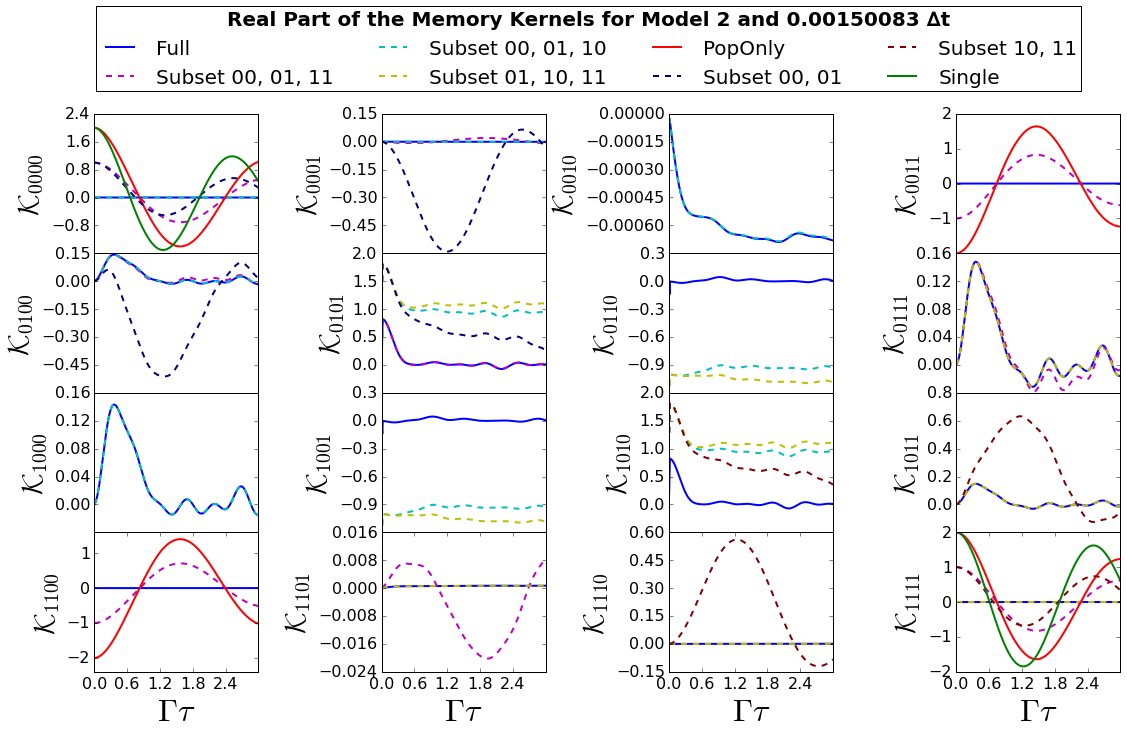

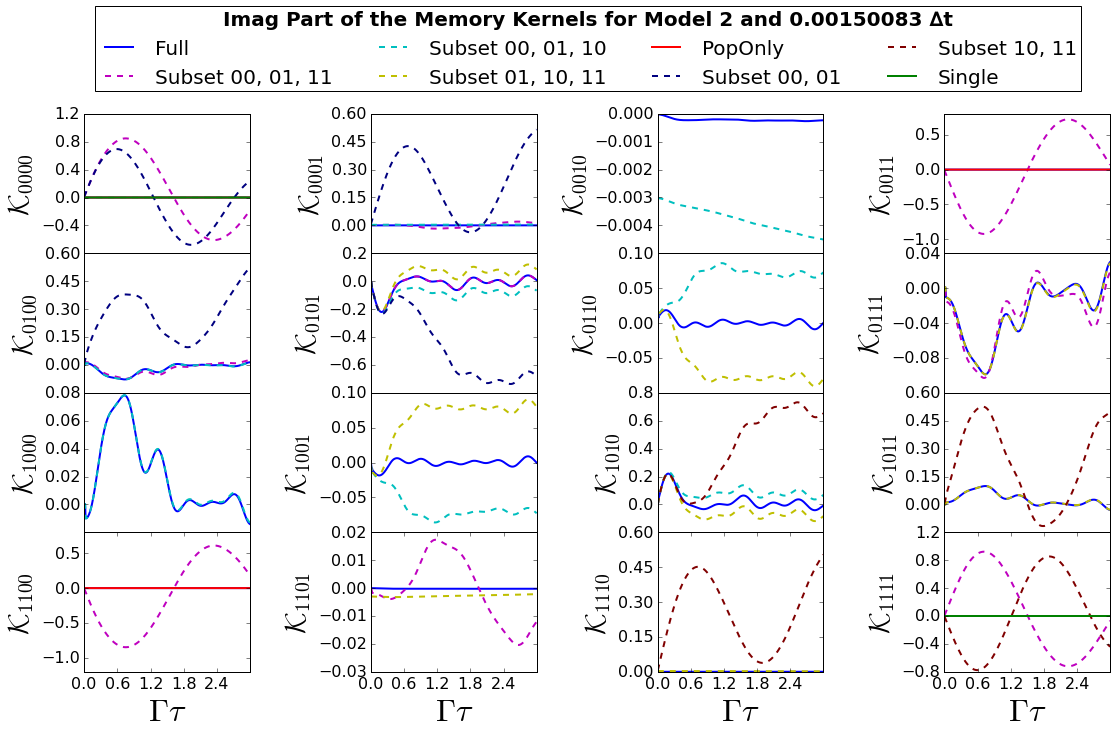

In [11]:
# array specifying GQME types to be graphed
GQMETypes = ["Full", "SubsetStates", "SubsetStates", "SubsetStates",
             "PopulationsOnly", "SubsetStates", "SubsetStates", "SingleState",
             "SingleState"]
# array of arrays specifing states in for matching index in GQMETypes
# for Full and Populations-Only GQMEs, a placeholder array can and must be put
# in, but it doesn't have to be all the states in Full and Populations-Only
statesPerType = [["All"], ["00", "01", "11"], ["00", "01", "10"],
                 ["01", "10", "11"], ["Pops"], ["00", "01"], ["10", "11"],
                 ["00"], ["11"]]

# states in largest subset; determines size of graphs grid. Put states in order.
# note that if looking at subsets, maxSet must include all states in the subsets
# (e.g., if including subsets ["00", "01"] and ["00", "10", "11"],
#   maxSet = ["00", "01", "10", "11"])
maxSet = ["00", "01", "10", "11"]

K_Dict = {} # dictionary to hold memory kernels

# pulls in memory kernels into K_Dict and time array
time = buildKDict(GQMETypes, statesPerType, K_Dict)

# number of columns in legend; good to do a maximum of 4
numCols = 4
# x position of legend, picks number that matches number in maxSet (increasing moves more right)
legendPos_x = [.15, .4, .65, 1.05]
# y position of legend, picks number that matches number in maxSet (increasing moves more up)
legendPos_y = [.58, .65, .85, .90]
graph_K("Real", GQMETypes, statesPerType, maxSet, numCols, legendPos_x,
        legendPos_y, time, K_Dict)
graph_K("Imag", GQMETypes, statesPerType, maxSet, numCols, legendPos_x,
        legendPos_y, time, K_Dict)


## **7. Calculating the Inhomogeneous Term**

$\quad$ The Volterra equation for the inhomogeneous term is given by the equation below

\begin{align}
I^{\text{sub}}_{jk}(t) & = Z^{jk}(t) + i\sum_{lm\,\in\{ab\}} {\cal F}_{jk,lm}(t) \sigma_{lm}(0)\notag \\
& + i \sum_{uv\,\in\{ab\}}\int_0^t d\tau\, {\cal F}_{jk,uv}(t - \tau) I^{\text{sub}}_{uv}(\tau)
\end{align}

$\quad$ Because $\sigma_{lm}(0) = 0$ for all $lm$ not equal to $00$ and because $\{ab\}$ will not contain $00$ for any subset that needs an inhomogeneous term, so the second term on the RHS will be zero so the Volterra equation will be

\begin{align}   
I^{\text{sub}}_{jk}(t) = Z^{jk}(t) + i \sum_{uv\,\in\{ab\}}\int_0^t d\tau\, {\cal F}_{jk,uv}(t - \tau) I^{\text{sub}}_{uv}(\tau)
\end{align}

$\quad$ The initial state is of the form $\hat{\rho}(0) = |0\rangle\langle 0 | \otimes \hat{\rho}_n(0)$, so $Z^{jk}(t) = -i {\cal F}_{jk,00}(t)$.

$\quad$ In the following subsections, we will calculate the inhomogeneous term using an iterative algorithm with ${\cal F}(\tau)$ as input.

$\quad$ NOTE: If your subset of interest contains the initial electronic state, it is unnecessary to calculate an inhomogeneous term and this section can be skipped to Sec. 8. For the spin-boson model here, the initial electronic states is $\hat\sigma(0) = |0\rangle\langle 0|$ so the only GQMEs that require an inhomogeneous term are single-state GQMEs for a state other than "00" and subset-states GQMEs where the subset does not contain "00".

## **7.1 Constants**
$\quad$ This subsection defines the constants used within the inhomogeneous term calculation.


In [12]:
### specific constants to the inhomogeneous term code ###
INTEGRAL_STEP_I = (TIME_STEPS * DT - DT)/(TIME_STEPS - 1)
# size of slice in integral, often written h = (x_b - x_a)/N
# [[Note: N = TIME_STEPS - 1 because there are TIME_STEPS - 1 slices, since
#   TIME_STEPS includes a count for t = 0]]
MAX_ITERS = 30 # maximum number of iterations for I
CONVERGENCE_PARAM = 10.**(-10.) # convergence parameter for volterra iterations


## **7.2 Read in Time Vector and Projection-Free Inputs ${\cal F}(t)$ and $\hat{Z}(t)$**
$\quad$ This subsection reads in the values of time and the projection-free input (PFI) ${\cal F}(t)$ from files, including the element(s) of ${\cal F}(t)$ needed for $\hat Z(t)$.


In [13]:
### variables ###
timeVec = np.zeros((TIME_STEPS))
F = np.zeros((TIME_STEPS, numStates, numStates), dtype=np.complex_)
Z = np.zeros((TIME_STEPS, numStates), dtype=np.complex_)
for j in range(numStates):
    ZStatesStr = states[j] + INITIAL_STATE

    t, Zreal, Zimag = np.hsplit(
        np.loadtxt("ProjFree_Output/F_" + ZStatesStr + PARAM_STR + ".txt"), 3)

    for i in range(TIME_STEPS):
        timeVec[i] = t[i]
        Z[i][j] = -1. * 1.j * (Zreal[i] + 1.j * Zimag[i])

    for k in range(numStates):
        statesStr = states[j] + states[k]

        t, Freal, Fimag = np.hsplit(
            np.loadtxt("ProjFree_Output/F_" + statesStr + PARAM_STR + ".txt"), 3)

        for i in range(TIME_STEPS):
            F[i][j][k] = Freal[i] + 1.j * Fimag[i]


## **7.3 Iterative Volterra Algorithm**

$\quad$ These subsections will calculate the inhomogeneous term via an interative algorithm. Starting with the general formula for a convolution Volterra equation of the second kind:
\begin{equation*}
\hat I(t) = g(t) + \int_{0}^t f(t - \tau)\hat I(\tau)d\tau
\end{equation*}
The iterative algorithm works by starting with a guess of $\hat I(t) = g(t)$ and keeps replacing it until it converges:
\begin{align*}
\hat I^{\color{purple} 0}(t) &= g(t)
\\ \hat I^{\color{purple} 1}(t) &= g(t) + \int_{0}^t d\tau f(t - \tau) \hat I^{\color{purple} 0}(\tau)
\\ \hat I^{\color{purple} 2}(t) &= g(t) + \int_{0}^t d\tau f(t - \tau) \hat I^{\color{purple} 1}(\tau)
\\ \vdots
\\ \hat I^{\color{purple} i}(t) &= g(t) + \int_{0}^t d\tau f(t - \tau) \hat I^{\color{purple} i-1}(\tau) \qquad  \text{where} \quad |\hat I^{\color{purple} i}(t) - \hat I^{\color{purple} i-1}(t)|\ \leq 10^{-10}
\end{align*}

$\quad$ To do this in an algorithm, we calculate $\hat I(n\Delta t)$ [where $n = 0, 1, 2, ..., N$ and $N\Delta t = t$] at many time steps and store them to get $\hat I^{\color{purple} iteration}(n\Delta t)$:
\begin{align*}
\hat I^{\color{purple} 0}(n\Delta t) &= g(n\Delta t)
\\ \hat I^{\color{purple} 1}(n\Delta t) &= g(n\Delta t) + \int_0^{n\Delta t} d\tau f(n\Delta t - \tau) \hat I^{\color{purple} 0}(\tau)
\\ \hat I^{\color{purple} 2}(n\Delta t) &= g(n\Delta t) + \int_0^{n\Delta t} d\tau f(n\Delta t - \tau) \hat I^{\color{purple} 1}(\tau)
\\ \vdots
\\ \hat I^{\color{purple} i}(n\Delta t) &= g(n\Delta t) + \int_0^{n\Delta t} d\tau f(n\Delta t - \tau) \hat I^{\color{purple} i-1}(\tau) \qquad  \text{where} \quad |\hat I^{\color{purple} i}(n\Delta t) - \hat I^{\color{purple} i-1}(n\Delta t)|\ \leq 10^{-10}
\end{align*}

$\quad$ The algorithm works by first calculating the integral from $0$ to $n\Delta t$ using the trapezoidal rule with $f(n\Delta t - \tau)$ and $\hat I^{\color{purple} i-1}(s)$ and then adding $g(n\Delta t)$ to get $\hat I^{\color{purple} i}(n\Delta t)$.

$\quad$ To check convergence, we see if $\ |\hat I_{jk}^{\text{sub},\ {\color{purple} i}}(n\Delta t) - \hat I_{jk}^{\text{sub},\ {\color{purple} i-1}}(n\Delta t)| \leq 10^{-10}\ $ for all vector elements $j,k$ and time steps $n$.



## **7.3.1 Function to Calculate Integral via Trapezoidal Rule**

$\quad$ This function calculates the integral part of the Volterra equation,
\begin{align}   
 i \sum_{uv\,\in\{ab\}}\int_0^t d\tau\, {\cal F}_{jk,uv}(t - \tau) I^{\text{sub}}_{uv}(\tau)
\end{align}

via the extended trapezoidal rule and then adding the linear part obtained in Sec. 4.2.

$\quad$ The extended trapezoidal rule approximates an integral on a uniform grid with $N$ slices as:
$$
\int_a^b f(t) dt \approx h\bigg[\frac{1}{2} f(a) + \frac{1}{2} f(b) + \sum_{k = 1}^{N-1} f(a + k * h)\Bigg],
$$
where $h = (a - b)\,/\,N$.


In [14]:
def CalculateIntegral(numStates, F, Z, prevITerm, iTerm):
    global TIME_STEPS, INTEGRAL_STEP_I

    for n in range(1, TIME_STEPS):
        for i in range(numStates):
            iTerm[n][i] = 0.
            for j in range(numStates):
                iTerm[n][i] += 0.5 * INTEGRAL_STEP_I * F[n][i][j] * iTerm[0][j]
                iTerm[n][i] += 0.5 * INTEGRAL_STEP_I * F[0][i][j] * prevITerm[n][j]
                for c in range(1, n):
                    iTerm[n][i] += INTEGRAL_STEP_I * F[n - c][i][j] * iTerm[c][j]

            iTerm[n][i] = 1.j * iTerm[n][i] + Z[n][i]

    return iTerm


## **7.3.2 Volterra Algorithm**

$\quad$ This section actually calculates the iterative Volterra algorithm described in Sec. 4.3.


In [15]:
prevITerm = np.zeros((TIME_STEPS, numStates), dtype=np.complex_)
iTerm = np.zeros((TIME_STEPS, numStates), dtype=np.complex_)

prevITerm = Z.copy()
iTerm[0] = Z[0].copy()

for numIter in range(1, MAX_ITERS + 1):
    print("Iteration:", numIter)

    iTerm = CalculateIntegral(numStates, F, Z, prevITerm, iTerm)

    numConv = 0
    for i in range(numStates):
        for n in range(TIME_STEPS):
            if abs(iTerm[n][i] - prevITerm[n][i]) <= CONVERGENCE_PARAM:
                numConv += 1
            elif numIter == MAX_ITERS:
                print("\tK time step and matrix element that didn't converge: %s, %s"%(n,i))
                print("\t\tprevITerm:", prevITerm[n][i])
                print("\t\t    ITerm:", iTerm[n][i])

    if numConv == TIME_STEPS * numStates:
        print("Number of Iterations:", numIter)

        PrintITerm(numStates, timeVec, iTerm)

        break

    prevITerm = iTerm.copy()
    iTerm = np.zeros((TIME_STEPS, numStates), dtype=np.complex_)
    iTerm[0] = Z[0].copy()

    if numIter == MAX_ITERS:
        print("\tERROR: Did not converge for %s iterations"%MAX_ITERS)


Iteration: 1
Iteration: 2
Iteration: 3
Number of Iterations: 3


## **7.4 Graphing the Inhomogeneous Term**

$\quad$ This subsection will graph the memory kernel(s) based on the GQME types specified in the array "GQMETypes". There is an additional array necessary, "statesPerType", that specifies the states that are part of each GQME type in "GQMETypes". Therefore, "statesPerType" needs to be an array of arrays that is the same length overall as "GQMETypes".

$\quad$ For single-state and subset-states GQMEs in "GQMETypes", the matching element within "statesPerType" should be an array of strings specifying the indices of the state(s) within the subset of interest.

$\quad$ For full GQME, populations-only GQME, and any subset-states GQME that contains "00", an inhomogeneous term is not needed.

$\quad$ The graphs will be a vertical stack of 1 to 3 graphs, depending on the single-state or subset-states GQME type(s) of interest.


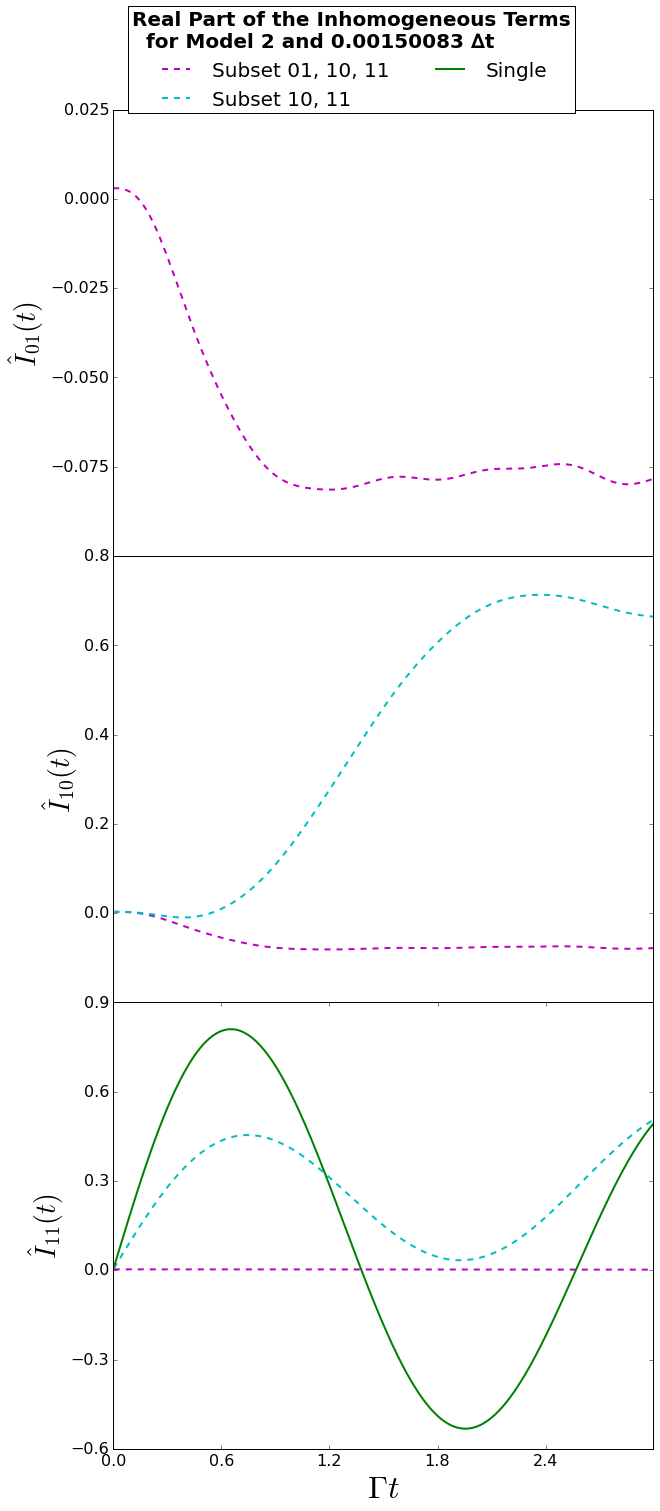

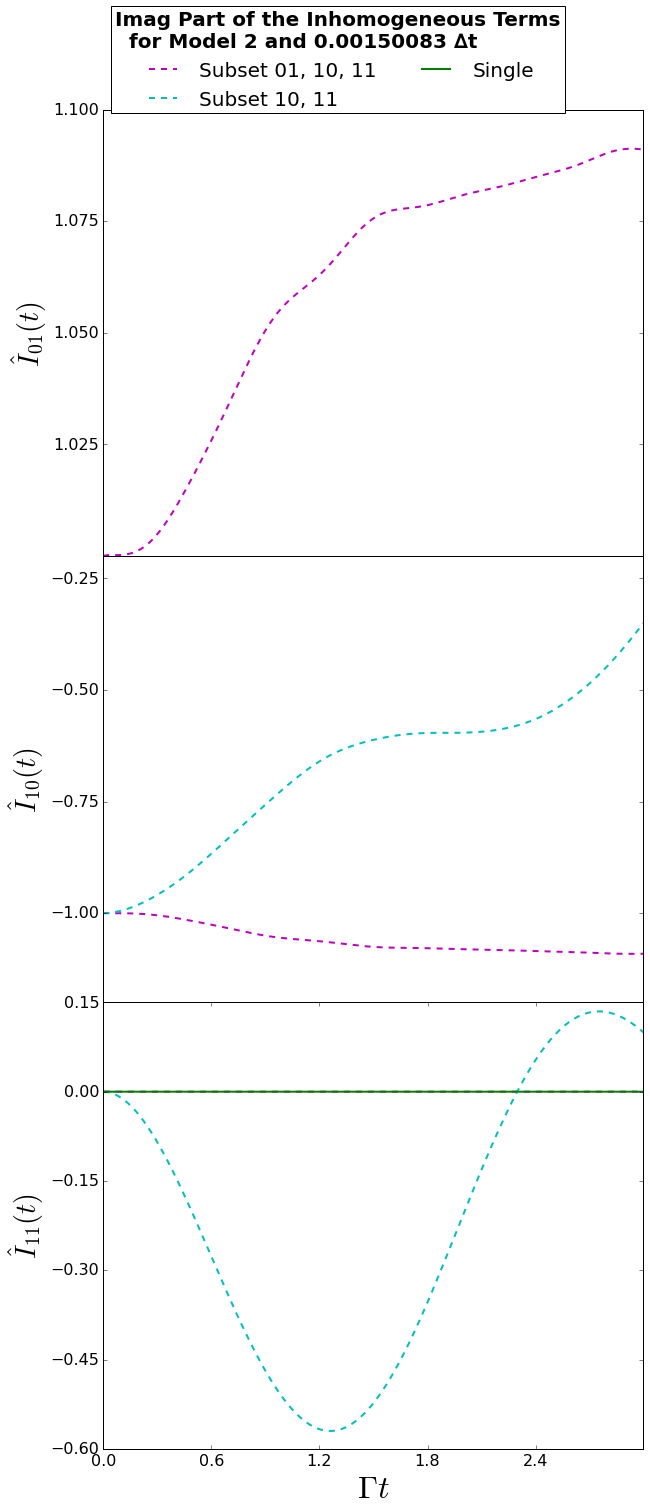

In [16]:
# array specifying GQME types to be graphed. Only SingleState and SubsetStates
# types will need an inhomogeneous term
GQMETypes = ["SubsetStates", "SubsetStates", "SingleState"]
# array of arrays specifing states in for matching index in GQMETypes
statesPerType = [["01", "10", "11"], ["10", "11"], ["11"]]

# states in largest subset; determines size of graphs grid. Put states in order.
# note that if looking at subsets, maxSet must include all states in the subsets
# (e.g., if including subsets ["01", "11"] and ["10", "11"],
#   maxSet = ["01", "10", "11"])
maxSet = ["01", "10", "11"]

I_Dict = {} # dictionary to hold memory kernels

# pulls in memory kernels into K_Dict and time array
time = buildIDict(GQMETypes, statesPerType, I_Dict)

# number of columns in legend; good to do either number of GQMETypes or half
# number of GQMETypes, if more than 4 GQMETypes
numCols = 2
legendPos_x = 0.15 # x position of legend (increasing moves more right)
legendPos_y = .6 + .01 * (len(maxSet) - 1) # y position of legend (increasing moves more up)
graph_I("Real", GQMETypes, statesPerType, maxSet, numCols, legendPos_x,
        legendPos_y, time, I_Dict)
graph_I("Imag", GQMETypes, statesPerType, maxSet, numCols, legendPos_x,
        legendPos_y, time, I_Dict)


## **8. Calculating the GQME**

$\quad$ This section will calculate the GQMEs. The GQME for any element $\sigma_{jk}(t)$ of the electronic density matrix within the subset of electronic DOF of interest $\{\hat\sigma_{ab}(t)\}$ has the form obtained from Eq. \ref{gqme_gen}, stated below

\begin{align}
\frac{d}{dt}\sigma_{jk}(t) = -\frac{i}{\hbar} \sum_{lm\,\in\{ab\}}\langle{\cal L}_{jk,lm}\rangle_n^0\hat\sigma_{lm}(t) - \sum_{lm\,\in\{ab\}}\int_0^t d\tau {\cal K}^{\text{sub}}_{jk,lm}(\tau) \hat\sigma_{lm}(t - \tau) + \hat I_{jk}^{\text{sub}}
\end{align}


$\quad$ In reality, we will calculate all of the $N_{\text{sub}}$ electronic density matrix elements within the subset of interest as a vector, with $\langle{\cal L}_{jk,lm}\rangle_n^0$ a $N_{\text{sub}} \times N_{\text{sub}}$ time-independent matrix, ${\cal K}^{\text{sub}}(\tau)$ $N_{\text{sub}} \times N_{\text{sub}}$ time-dependent matrix, and $\hat I^{\text{sub}}$ a $N_{\text{sub}}$-dimensional time-dependent vector.


## **8.1 Calculating the GQME**

$\quad$ This subsection defines the constants and variables used within the GQME calculation.


In [17]:
### specific constants to the memory kernel code ###
MEM_TIME = DT * TIME_STEPS # Either the memory time for straight calculation or
# for convergence
MEM_TIMESTEPS = int(MEM_TIME/DT)
FINAL_TIME_GQME = MEM_TIME + DT
FINAL_TIMESTEPS = int(FINAL_TIME/DT)

### setting parameter string GQME ###
PARAM_STR_GQME = PARAM_STR + "_mt%.4f_finalt%.4f"%(MEM_TIME, FINAL_TIME_GQME)

### variables ###
timeVec = np.arange(0, FINAL_TIMESTEPS * DT, DT)


## **8.2 Functions for the 4th-Order Runge-Kutta Method (RK4)**

$\quad$ The GQME is solved using the RK4 method. This method is used to solve equations of the form

$$\frac{dy}{dt} = f(t, y) \ \ \ \text{with an initial value}\ \ \ y(t_0) = y_0.$$

$\quad$ In the case of the GQME, $y = \sigma_{jk}$,$\ $ $y_0 = \langle j|0\rangle\langle 0|k\rangle$,$\ $ and
$$
f\big(t, \sigma_{jk}\big) = -\frac{i}{\hbar} \sum_{lm\,\in\{ab\}}\langle{\cal L}_{jk,lm}\rangle_n^0\hat\sigma_{lm}(t) - \sum_{lm\,\in\{ab\}}\int_0^t d\tau {\cal K}^{\text{sub}}_{jk,lm}(\tau) \hat\sigma_{lm}(t - \tau) + \hat I_{jk}^{\text{sub}}.
$$

$\quad$ The RK4 method then works step-wise with time step $h$ so $t_{n + 1} = t_n + h$ (with $n = 0, 1, 2, ...$) and
$$
\sigma_{jk}^{n + 1} = \sigma_{jk}^n + \frac{h}{6}\big(k_1 + 2k_2 + 2k_3 + k_4\big),
$$
where $\sigma_{jk}^{n + 1} = \sigma_{jk}(t_{n + 1})$ and

\begin{align*}
k_1 &= f\big(t_n, \sigma_{jk}^n\big)
\\ k_2 &= f\bigg(t_n + \frac{h}{2}, \sigma_{jk}^n + \frac{h}{2}k_1\bigg)
\\ k_3 &= f\bigg(t_n + \frac{h}{2}, \sigma_{jk}^n + \frac{h}{2}k_2\bigg)
\\ k_4 &= f\big(t_n + h, \sigma_{jk}^n + hk_3\big).
\end{align*}


$\quad$ We will solve the integral in $f(t, \sigma_{jk})$ using the extended trapezoidal rule.

$\quad$ In the code, we will not calculate each element of $\hat\sigma^{\text{sub}}(t)$ individually but instead as a vector. This means $y = \hat\sigma^{\text{sub}}(t)$,$\ $ $y_0 = \sum\limits_{jk\,\in\,\{ab\}} \big(\langle j|0\rangle\langle 0|k\rangle\big)\,|j\rangle\langle k|$,$\ $ and
$$
f\big(t, \hat\sigma^{\text{sub}}\big) = -\frac{i}{\hbar} \sum_{lm\,\in\{ab\}}\langle{\cal L}_{jk,lm}\rangle_n^0\hat\sigma_{lm}(t) - \sum_{lm\,\in\{ab\}}\int_0^t d\tau {\cal K}^{\text{sub}}_{jk,lm}(\tau) \hat\sigma_{lm}(t - \tau) + \hat I_{jk}^{\text{sub}}.
$$

$\quad$ It should be noted that because $f(t, \sigma_{jk})$ contains an integral solved via the extended trapezoidal rule, the error of the RK4 is not actually fourth order in $h$ but first order.


## **8.2.1 Calculating the function $f$ of the Runge-Kutta 4th-Order Method**

$\quad$ This function calculates the function making up the RHS of the RK4 method:
\begin{align}
    f\big(t, \sigma_{jk}\big) = -\frac{i}{\hbar} \sum_{lm\,\in\{ab\}}\langle{\cal L}_{jk,lm}\rangle_n^0\hat\sigma_{lm}(t) - \sum_{lm\,\in\{ab\}}\int_0^t d\tau {\cal K}^{\text{sub}}_{jk,lm}(\tau) \hat\sigma_{lm}(t - \tau) + \hat I_{jk}^{\text{sub}}
\end{align}


In [18]:
def Calculatef(numStates, states, initInSubset, currentTime, memTime, kernel,
               iTerm, sigma, kVec):
    global LN0, HBAR

    memTimeSteps = int(memTime / DT)
    currentTimeStep = int(currentTime / DT)

    f = np.zeros(numStates, dtype=np.complex_)

    for i in range(numStates):
        for j in range(numStates):
            index_jk = DOF_E * int(states[i][0]) + int(states[i][1])
            index_lm = DOF_E * int(states[j][0]) + int(states[j][1])
            f[i] -= 1.j / HBAR * LN0[index_jk][index_lm] * kVec[j]
        if initInSubset == False:
            f[i] += iTerm[currentTimeStep][i]

        memory = 0.
        limit = memTimeSteps
        if currentTimeStep < (memTimeSteps - 1):
            limit = currentTimeStep
        for j in range(numStates):
            for l in range(limit):
                memory -= DT * kernel[l][i][j] * sigma[currentTimeStep - l][j]

        f[i] += memory

    return f


## **8.2.2 Propagation via Runge-Kutta 4th-Order Method**

$\quad$ This function propagates $\hat\sigma^{\text{sub}}$ to the next time step using
\begin{align}
    \hat\sigma^{\text{sub}}(t_{n + 1}) = \hat\sigma^{\text{sub}}(t_{n}) + \frac{h}{6}\big(k_1 + 2k_2 + 2k_3 + k_4\big)
\end{align}

where $\sigma_{jk}^{n + 1} = \sigma_{jk}(t_{n + 1})$ and

\begin{align}
k_1 &= f\big(t_n, \sigma_{jk}^n\big) \notag
\\ k_2 &= f\bigg(t_n + \frac{h}{2}, \sigma_{jk}^n + \frac{h}{2}k_1\bigg) \notag
\\ k_3 &= f\bigg(t_n + \frac{h}{2}, \sigma_{jk}^n + \frac{h}{2}k_2\bigg) \notag
\\ k_4 &= f\big(t_n + h, \sigma_{jk}^n + hk_3\big).
\end{align}


In [19]:
def PropagateRK4(numStates, states, initInSubset, currentTime, memTime, kernel,
                 iTerm, sigma_hold, sigma):
    global LN0, HBAR

    f_0 = np.zeros(numStates, dtype = np.complex_)
    f_1 = np.zeros(numStates, dtype = np.complex_)
    f_2 = np.zeros(numStates, dtype = np.complex_)
    f_3 = np.zeros(numStates, dtype = np.complex_)
    k_1 = np.zeros(numStates, dtype = np.complex_)
    k_2 = np.zeros(numStates, dtype = np.complex_)
    k_3 = np.zeros(numStates, dtype = np.complex_)

    f_0 = Calculatef(numStates, states, initInSubset, currentTime, memTime,
                     kernel, iTerm, sigma, sigma_hold)

    t_1 = currentTime + DT / 2.
    k_1 = sigma_hold + DT * f_0 / 2.
    f_1 = Calculatef(numStates, states, initInSubset, t_1, memTime,
                     kernel, iTerm, sigma, k_1)

    t_2 = currentTime + DT / 2.
    k_2 = sigma_hold + DT * f_1 /2.
    f_2 = Calculatef(numStates, states, initInSubset, t_2, memTime,
                     kernel, iTerm, sigma, k_2)

    t_3 = currentTime + DT
    k_3 = sigma_hold + DT * f_2
    f_3 = Calculatef(numStates, states, initInSubset, t_3, memTime,
                     kernel, iTerm, sigma, k_3)

    sigma_hold += DT / 6. * (f_0 + 2. * f_1 + 2. * f_2 + f_3)

    return sigma_hold

## **8.3 Propagation of the Density Matrix**

$\quad$ This subsection does the propagation of the subset of electronic density matrix elements of interest, $\hat\sigma^{\text{sub}}$ with the RK4 method described in Sec. 5.2.



In [20]:
# array for subset of electronic density matrix elements of interest
sigma = np.zeros((FINAL_TIMESTEPS, numStates), dtype=np.complex_)
# array to hold copy of sigma
sigma_hold = np.zeros(numStates, dtype = np.complex_)

# if initial state is in subset, sets that state to 1
if initInSubset == True:
    sigma[0][initialIndex] = 1.
    sigma_hold[initialIndex] = 1.

# loop to propagate sigma
print(">>> Starting propagation, memory time =", MEM_TIME)
for l in range(FINAL_TIMESTEPS - 1): # it propagates to the final time step
    currentTime = l * DT

    PropagateRK4(numStates, states, initInSubset, currentTime, MEM_TIME, kernel,
                 iTerm, sigma_hold, sigma)

    sigma[l + 1] = sigma_hold.copy()

# prints sigma to files
print("Printing Sigma")
PrintGQMESigma(numStates, states, timeVec, sigma)

>>> Starting propagation, memory time = 3.001659990105585
Printing Sigma


## **8.4 Graphing $\hat{\sigma}_z(t)$ from Files**

$\quad$ This subsection graphs the population difference $\sigma_z(t) = \sigma_{00}(t) - \sigma_{11}(t)$. This means that either the subset of interest must contain both $\sigma_{00}(t)$ and $\sigma_{11}(t)$ or there must be two subsets used, one with $\sigma_{00}(t)$ and one with $\sigma_{1}(t)$. If two subsets are used, generally we try to match subsets, e.g., single-state GQME for $\sigma_{00}(t)$ with single-state GQME for $\sigma_{11}(t)$ and subset-states GQME for $\{\sigma_{00}(t), \sigma_{01}(t), \sigma_{10}(t)\}$ with subset-states GQME for $\{\sigma_{01}(t), \sigma_{10}(t), \sigma_{11}(t)\}$.

$\quad$ This subsection will graph the population difference(s) based on the GQME types specified in the array "GQMETypes".  

$\quad$ The graph will be a single graph containing all population differences of interest.

$\quad$ This subsection does not need to be run directly after the previous subsections, as it will be pulling the values of the $\sigma_{00}(t)$ and $\sigma_{11}(t)$ from files.


## **8.4.1 Constants**
$\quad$ Constants used in graphing $\sigma_z(t)$.


In [21]:
### specific constants to the memory kernel code ###
MEM_TIME = DT * TIME_STEPS # memory time, aka length of memory kernel
MEM_TIMESTEPS = int(MEM_TIME/DT) # timesteps needed for memory time
FINAL_TIME_GQME = MEM_TIME + DT # final time of sigma propagation
FINAL_TIMESTEPS = int(FINAL_TIME/DT) # timesteps needed to reach final time
MAX_LOOPS_CONV = 20 # maximum number of loops within the convergence algorithm
CONV_LIMIT = 1. * pow(10.,-2.) # value that the difference between sigma_z(t)
# and sigma_{z,max}(t) must be <= to be considered converged
CONV_ALG_BIG_STEP = 2. # bigger time step within convergence algorithm
CONV_ALG_SMALL_STEP = 0.25 # smaller time step within convergence algorithm

### setting parameter string GQME ###
PARAM_STR_GQME = PARAM_STR + "_mt%.4f_finalt%.4f"%(MEM_TIME, FINAL_TIME_GQME)


## **8.4.2 Constants**
$\quad$ This subsection does the actual graphing of $\sigma_z(t)$ based on the GQME(s) specified in "GQMETypes". "GQMETypes" is an array of arrays, with its overall length equal to the number of $\sigma-z(t)$ lines from GQMEs and each element being an array specifying the GQME(s) used to obtain $\sigma_{00}(t)$ and $\sigma_{11}(t)$.

$\quad$ If one GQME is used to obtain both $\sigma_{00}(t)$ and $\sigma_{11}(t)$ (e.g., full), then the subarray has one element (e.g., ["Full"]). If two different GQMEs is used to obtain both $\sigma_{00}(t)$ and $\sigma_{11}(t)$ (e.g., $\sigma_{00}(t)$ from subset {00, 01} and $\sigma_{11}(t)$ from subset {10,11}), then the subarray has two elements, with the first being the GQME for $\sigma_{00}(t)$ and the second being the GQME for $\sigma_{11}(t)$ (e.g., ["Subset_00_01", "Subset_10_11"]).

$\quad$ For all subset-states GQMEs, they must be specified as "Subset_" followed by the states in their subet separated by underscores, e.g., subset-states GQME for {00, 01, 11} should be written "Subset_00_01_11" within "GQMETypes". It is not necessary to do this for the SingleState GQMEs because it knows to use the single-state GQME for $\sigma_{00}(t)$ if it is listed first or the single-state GQME for $\sigma_{11}(t)$ if it is listed second.

$\quad$ As a note, you can combine two different GQMEs that have both $\sigma_{00}(t)$ and $\sigma_{11}(t)$ in their subsets, e.g., ["Full", "PopulationsOnly"], and it will pull $\sigma_{00}(t)$ from the first one specified and $\sigma_{11}(t)$ from the second one specified, but this is somewhat strange. Generally, if we can, we pull both populations from the same subset. Additionally, if we can't, we usually try to match similar subsets, e.g., if we use a single-state GQME for $\sigma_{00}(t)$, we also use a single-state GQME for $\sigma_{11}(t)$; if we use a two-state subset-states GQME for $\sigma_{00}(t)$, we also use a two-state subset-states GQME for $\sigma_{11}(t)$; etc.

$\quad$ The figures are stored in "Figures/GQME_Graphs" and the file name will contain the GQME types specified in "GQMETypes".


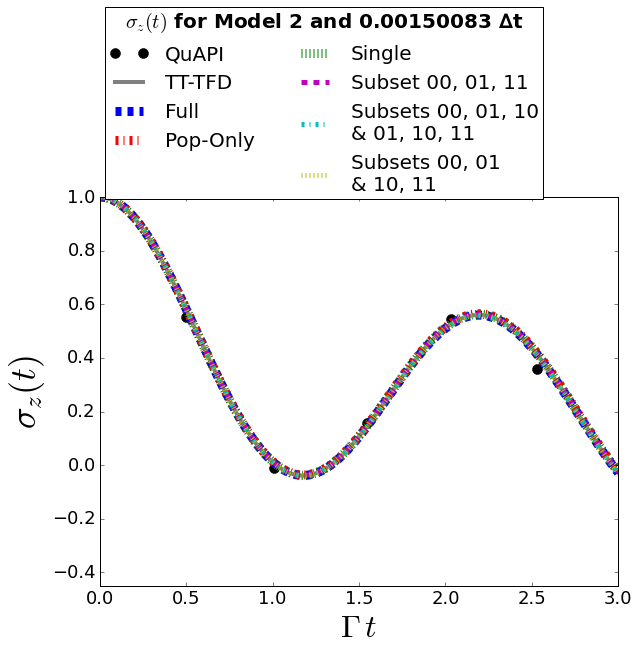

In [22]:
GQMETypes = [["Full"], ["PopulationsOnly"], ["SingleState", "SingleState"],
             ["Subset_00_01_11"], ["Subset_00_01_10", "Subset_01_10_11"],
             ["Subset_00_01", "Subset_10_11"]]

time_U, U, time, sigmaZDict = dataUandGQME(GQMETypes)

numCols = 2 # number of columns in legend; generally should be 2
legendPos_x = 0.15 # x position of legend (increasing moves more right)
# y position of legend (increasing moves more up)
legendPos_y = .63 + 0.06 * (math.ceil((len(GQMETypes) + 2)/2) - 2)
graphSigmaZ(GQMETypes, numCols, legendPos_x, legendPos_y, time_U, U, time, sigmaZDict)
